In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import lightgbm
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Credit Card Fraud Detection

고객이 구매하지 않은 항목에 대해 비용이 청구되지 않도록 신용 카드 회사가 사기 신용 카드 거래를 인식할 수 있는 것이 중요합니다.

콘텐츠

데이터 세트에는 2013년 9월 유럽 카드 소지자가 신용 카드로 수행한 거래가 포함되어 있습니다.
이 데이터 세트는 284,807건의 거래 중 492건의 사기가 있는 2일 동안 발생한 거래를 나타냅니다. 데이터 세트는 매우 불균형하며 긍정적인 클래스(사기)가 모든 거래의 0.172%를 차지합니다.

여기에는 PCA 변환의 결과인 숫자 입력 변수만 포함됩니다. 유감스럽게도 기밀 문제로 인해 원본 기능과 데이터에 대한 자세한 배경 정보를 제공할 수 없습니다. 피처 V1, V2, … V28은 PCA로 얻은 주요 구성 요소이며 PCA로 변환되지 않은 유일한 특징은 '시간'과 '양'입니다. 피처 '시간'에는 각 트랜잭션과 데이터 세트의 첫 번째 트랜잭션 사이에 경과된 초가 포함됩니다. 'Amount' 기능은 거래 금액이며, 이 기능은  비용에 민감한 학습(example-dependant cost-sensitive learning)에 사용할 수 있습니다. Feature 'Class'는 응답 변수이며 사기의 경우 값 1, 그렇지 않은 경우 0입니다.

과제2_0525.
주어진 데이터셋으로 아래와 같이 모델링 및 평가를 수행하세요.
- 로지스틱 회귀와  LightGBM 모델을 사용하여 모델 학습, 예측, 평가
- 중요한 변수로 Amount 피처를 표준화한 후 모델 학습, 예측, 평가
- Amount 피처를 로그 변환한 후 모델 학습, 예측, 평가
- 이상치 데이터를 처리한 후 모델 학습, 예측, 평가
- SMOTE 오버 샘플링 적용 후 모델 학습, 예측, 평가

In [3]:
card_df = pd.read_csv("dataSet/creditcard.csv")
card_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [13]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop("Time", axis = 1, inplace = True)
    return df_copy

In [6]:
def get_train_test_dataset(df = None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0, stratify = y_target)
    
    return X_train, X_test, y_train, y_test

In [10]:
card_df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [20]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [21]:
y_train.value_counts()/y_train.shape[0]*100

0    99.827451
1     0.172549
Name: Class, dtype: float64

In [26]:
y_test.value_counts()/y_test.shape[0]*100

0    99.826785
1     0.173215
Name: Class, dtype: float64

In [28]:
def get_clf_eval(y_test = None, pred = None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = round(accuracy_score(y_test, pred),4)
    precision = round(precision_score(y_test, pred),4)
    recall = round(recall_score(y_test, pred),4)
    f1 = round(f1_score(y_test, pred),4)
    roc_auc = round(roc_auc_score(y_test, pred_proba[:, 1]),4)
    print("오차 행렬")
    print(confusion)
    print(f"정확도 : {accuracy}, 정밀도 : {precision}\n재현율 : {recall}, f1 : {f1}")
    print(f"AUC : {roc_auc}")

In [35]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)

In [36]:
get_clf_eval(y_test, lr_preds, lr_pred_proba)

오차 행렬
[[85283    12]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8824
재현율 : 0.6081, f1 : 0.72
AUC : 0.962


In [39]:
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)
    get_clf_eval(tgt_test,pred,pred_proba)

In [40]:
# n_jobs = -1 : 학습 및 예측에 사용할 코어 수 최대로
# boost_from_average = False : 클래스 불균형 문제를 다루기 위해 LGBM의 특정 기능을 비활성화

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도 : 0.9995, 정밀도 : 0.9573
재현율 : 0.7568, f1 : 0.8453
AUC : 0.979


<AxesSubplot:xlabel='Amount', ylabel='Count'>

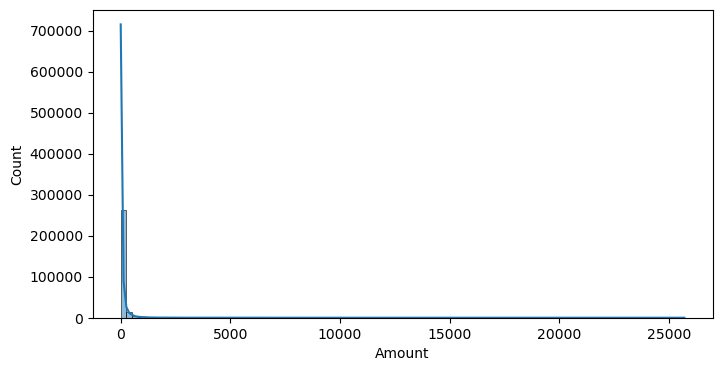

In [41]:
import seaborn as sns

plt.figure(figsize = (8,4))
sns.histplot(card_df["Amount"], bins = 100, kde = True)

In [42]:
card_df["Amount"].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [43]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy["Amount"].values.reshape(-1,1))
    
    df_copy.insert(0, "Amount_Scaled", amount_n)
    
    df_copy.drop(["Time", "Amount"], axis = 1, inplace = True)
    return df_copy

In [48]:
def get_train_test_dataset(df):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0, stratify = y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [50]:
print("### 로지스틱 회귀 예측 성능 ###")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)
print("### LightGBM 예측 성능 ###")
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8654
재현율 : 0.6081, f1 : 0.7143
AUC : 0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도 : 0.9995, 정밀도 : 0.9569
재현율 : 0.75, f1 : 0.8409
AUC : 0.9779


In [51]:
def get_preprocessed_df(df):
    df_copy = df.copy()
    # np.log1p(n) : n에 1을 더한 후 로그값을 게산, 입력값이 0 또는 음수인 경우에도 정의된 결과를 얻기 위함 
    amount_n = np.log1p(df_copy["Amount"])
    df_copy.insert(0, "Amount_Scaled", amount_n)
    df_copy.drop(["Time","Amount"], axis = 1, inplace = True)
    return df_copy

In [53]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print("### 로지스틱 회귀 예측 성능 ###")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)
print("### LightGBM 예측 성능 ###")
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도 : 0.9992, 정밀도 : 0.8812
재현율 : 0.6014, f1 : 0.7149
AUC : 0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도 : 0.9995, 정밀도 : 0.9576
재현율 : 0.7635, f1 : 0.8496
AUC : 0.9796


<AxesSubplot:>

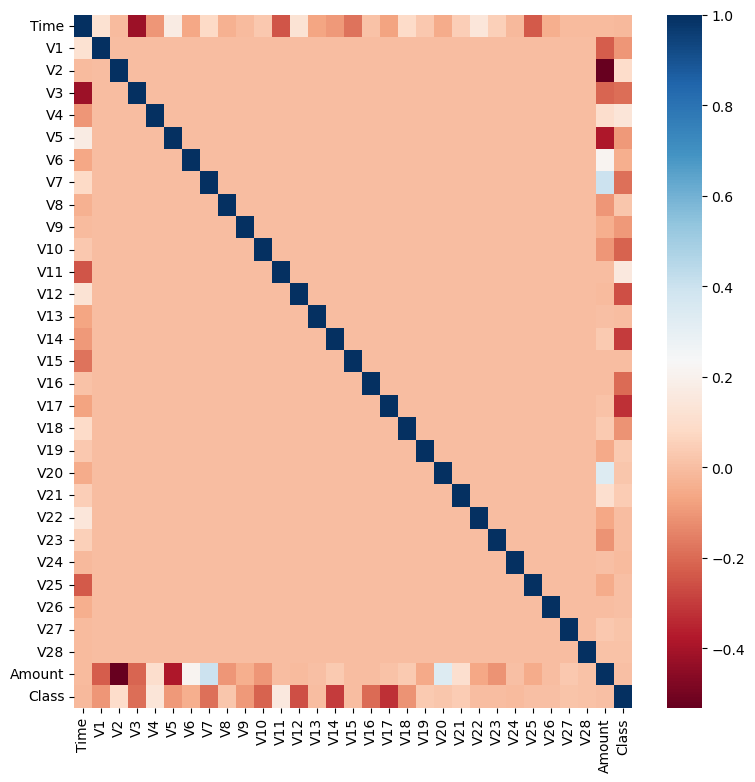

In [54]:
plt.figure(figsize = (9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap = "RdBu")

In [55]:
def get_outlier (df, column, weight):
    fraud = df[df["Class"] ==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [56]:
outlier_index = get_outlier(card_df, "V14", 1.5)
outlier_index

Int64Index([8296, 8615, 9035, 9252], dtype='int64')

In [59]:
def get_preprocessed_df(df):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy["Amount"])
    df_copy.insert(0, "Amount_Scaled", amount_n)
    outlier_index = get_outlier(card_df, "V14", 1.5)
    df_copy.drop(outlier_index, inplace = True)
    df_copy.drop(["Time","Amount"], axis = 1, inplace = True)
    return df_copy

In [60]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print("### 로지스틱 회귀 예측 성능 ###")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)
print("### LightGBM 예측 성능 ###")
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도 : 0.9993, 정밀도 : 0.875
재현율 : 0.6712, f1 : 0.7597
AUC : 0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도 : 0.9996, 정밀도 : 0.9603
재현율 : 0.8288, f1 : 0.8897
AUC : 0.978


### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
- imbalanced-learn 패키지의 SMOTE 클래스를 이용해 오버 샘플링 적용
- 반드시 학습 데이터 세트만 오버 샘플링 적용
- SMOTE를 적용하면 재현율은 높아지나 정밀도는 낮아지는 것이 일반적
- 좋은 SMOTE 패키지일수록 재현율 증가율은 높이고 정밀도 감소율은 낮출 수 있도록 효과적으로 데이터 증식

In [62]:
import sklearn
sklearn.__version__

'1.0.2'

In [63]:
!pip install imbalanced-learn

     -------------------------------------- 226.0/226.0 kB 7.0 MB/s eta 0:00:00
     -------------------------------------- 298.0/298.0 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [64]:
from imblearn.over_sampling import SMOTE

In [66]:
smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape)
print(X_train_over.shape, y_train_over.shape)
print(pd.Series(y_train_over).value_counts())

(199362, 29) (199362,)
(398040, 29) (398040,)
0    199020
1    199020
Name: Class, dtype: int64


In [68]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print("### 로지스틱 회귀 예측 성능 ###")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)
print("### LightGBM 예측 성능 ###")
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[82937  2358]
 [   11   135]]
정확도 : 0.9723, 정밀도 : 0.0542
재현율 : 0.9247, f1 : 0.1023
AUC : 0.9737
### LightGBM 예측 성능 ###
오차 행렬
[[85283    12]
 [   22   124]]
정확도 : 0.9996, 정밀도 : 0.9118
재현율 : 0.8493, f1 : 0.8794
AUC : 0.9814


In [69]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

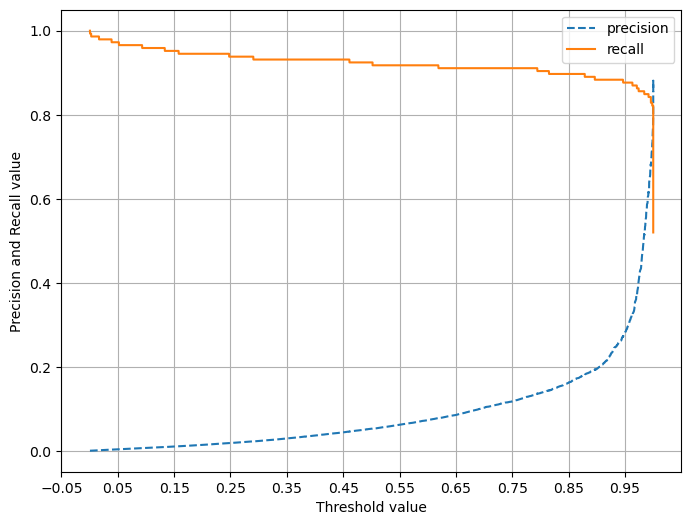

In [70]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

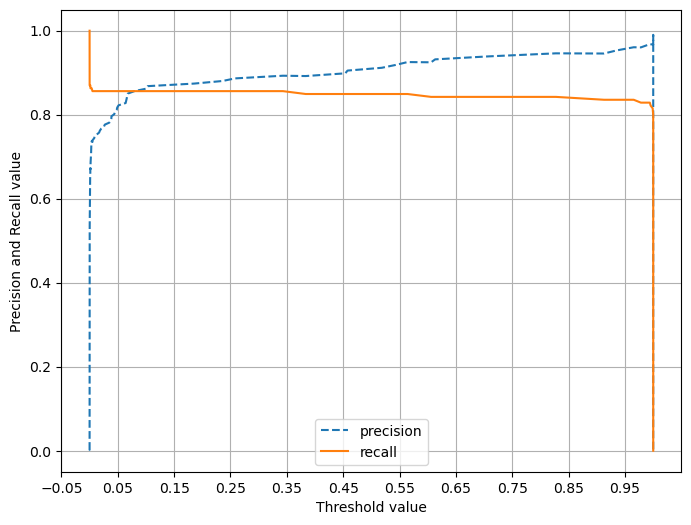

In [71]:
precision_recall_curve_plot(y_test, lgbm_clf.predict_proba(X_test)[:,1])

In [2]:
customerdata

NameError: name 'customerdata' is not defined